# Dependencies
Make sure pytorch, torchvision and GPU are avaliable. By default they should be preinstalled on CoLab.

In [ ]:
!nvidia-smi
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch import nn
import time

print(torch.__version__)
assert torch.cuda.is_available()

Wed Jun  1 16:29:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Configure Kaggle API

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download kaggle.json file on your machine.
3. Upload kaggle json



In [ ]:
from google.colab import files
!rm kaggle*
files.upload()

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Download Dataset
Time to find our dataset. Download a cat vs dog dataset from Kaggle


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'cats' # we can list all the dataset that has cats in it

ref                                                        title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shaunthesheep/microsoft-catsvsdogs-dataset                 Cats-vs-Dogs                                        788MB  2020-03-12 05:34:30          10870        175  0.875            
chetankv/dogs-cats-images                                  Dogs & Cats Images                                  435MB  2018-04-19 18:20:08          28014        527  0.5625           
mmoreaux/audio-cats-and-dogs                               Audio Cats and Dogs                                  97MB  2017-10-05 09:40:26           8510        218  0.7647059        
biaiscience/dogs-vs-cats                                   Dogs vs Cats              

In [ ]:
!kaggle datasets download tongpython/cat-and-dog # download cat and dog dataset

 96% 209M/218M [00:06<00:00, 39.0MB/s]
100% 218M/218M [00:06<00:00, 35.4MB/s]


Unzip dataset

In [ ]:
!unzip -q cat-and-dog.zip 

#Dataset Exploration

We want to get a sense of what the dataset looks like. There are sometimes unreliable and unorganized data, and this step will helps us get rid of them. We can also check if the dataset is what we think they are, if not we may need to rethink our approach.

For this tutorial, the datasets are all very clean, nevertheless we will still want to do some due deligence of checking them before we get started working with them.

Explore folder structure

In [ ]:
!ls  training_set/training_set/cats

In [ ]:
!ls  training_set/training_set/dogs

Within each class folder, we have the images. This is a very common folder structure for classification dataset.

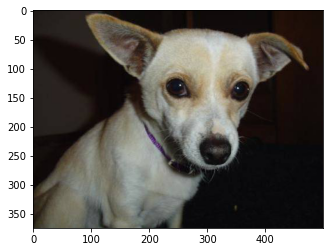

In [ ]:
import matplotlib.pyplot as plt # we will be using matplotlib to plot our images
import matplotlib.image as mpimg
# feel free to explore other images by changing the image path.
img_path = 'training_set/training_set/dogs/dog.104.jpg' # #@param {"type": "string"}
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()



# Splitting the Dataset

In machine learning, we typically need to split our dataset into train, validation, and test set. By spliting the dataset this way, we can use validation and test dataset to check if our model has overfitted the training data, meaning the model is memorizing the data instead of learning interesting pattern that can be generalized.

We will only split our data into train and test for simplicity in this example. In our example dataset of cats vs dogs, the developers of the dataset were kind enough to split the dataset for us. That is usually not the case, and if so, a good rule of thumb is to split of 70/30 or 80/20. 

In [ ]:
#dataset already split up in train vs test (75/25 split). Investigate the dog train/test breakdown below: 

!ls training_set/training_set/dogs/ | wc -l #the nr of samples in the train dataset for dogs
!ls test_set/test_set/dogs/ | wc -l #the nr of samples in the test dataset for dogs

4006
1013


In [ ]:
#dataset already split up in train vs test (75/25 split). Investigate the cat train/test breakdown below: 

!ls training_set/training_set/cats/ | wc -l #the nr of samples in the train dataset for cats
!ls test_set/test_set/cats/ | wc -l #the nr of samples in the test dataset for cats

4001
1012


#Setup PyTorch Dataset
Dataset is a helper module in PyTorch that loads raw data and convert it to tensors that can be consumed by PyTorch

In [ ]:
import os

center_crop_size = 224 #@param {"type": "integer"}

traindir = os.path.join('training_set', 'training_set') # define our training data path
valdir = os.path.join('test_set', 'test_set') # define our validation data path
# ImageNet mean and std. The reason we use ImageNet mean and std here is because we might want to use ImageNet pretrained network later.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([ # transform is for data preprocessing and augmentation. It helps alleviate overfiting. meaning the model works well on traning but not on validation and test.
        transforms.RandomResizedCrop(224), # crop a random patch of the image and resize it to a given size
        transforms.RandomHorizontalFlip(), # randomly mirror a image.
        transforms.ToTensor(), # convert this to pytorch tensor
        normalize, # normalize the tensor
    ]))
val_dataset = datasets.ImageFolder(
    valdir, 
    transforms.Compose([
        transforms.Resize(256), # for validation we don't need to do augmentation
        transforms.CenterCrop(center_crop_size),
        transforms.ToTensor(),
        normalize, # make sure you normalize your data the same way as training.
    ]))

# Data Augmentation
Data augmentation is very import, since it prevent the model from overfitting. The model will train on slightly different images each time it goes throught them.

Random Resized Crop illustration

![](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_012.png)

Random Flip illustration

![](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_022.png)

Let's check the size of our dataset.

In [ ]:
print('Train dataset size')
print(type(train_dataset)) # let's check the type of our dataset
print(len(train_dataset)) # let's check how large is our dataset.

#note val_dataset is the same as a test dataset
print("Test dataset size")
print(type(val_dataset)) # let's check the type of our dataset
print(len(val_dataset)) # let's check how large is our dataset.

Train dataset size
<class 'torchvision.datasets.folder.ImageFolder'>
8005
Test dataset size
<class 'torchvision.datasets.folder.ImageFolder'>
2023


# Dataloader
Setup PyTorch Dataloader. Training a model with one sample at a time is possibile but is does not utilize our GPU very efficiently as most of the time will be spent on transfering data from CPU and GPU. We want to leverage the massive parallel processing capabilites. Usually we try to maxout the GPU memory when we batch our training samples to achieve the highest efficiency.

In [ ]:
batch_size = 64 #@param {"type": "integer"}
num_workers = 2 #@param {"type": "integer"}
shuffle = True #@param {"type": "boolean"}

train_loader = torch.utils.data.DataLoader( # dataloader batchify individual training samples.
        train_dataset, batch_size=batch_size, # set batchsize
        shuffle=True, num_workers=num_workers, # shuffle our dataset makes the optimization more stable, and the final model generalize better. 
        # num_workers define how many worker will be assign for data preprocess
        pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True)

In [ ]:
print(type(train_loader))
print(len(train_loader)) # as we can see here the length of the loader is smaller after batching

<class 'torch.utils.data.dataloader.DataLoader'>
126


# Model Performance Metrics

Metrics. We use top 1 accuracy for this class. The simplest merics. This is from PyTorch examples.


In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

# MobileNet V3
Import MobileNet V3 small. MobileNet V3 is a model produced by nerual architecture search in 2019. It produces superior accuracy with less computation.

https://arxiv.org/abs/1905.02244


The default MobileNet V3 won't work in SnapML due to unsuported operators. HardSigmoid and HardSwish are not supported in SnapML.

In the code below you will see a function that swaps up the unspported operators with supported ones. In this case, hardsigmoid is replaced with sigmoid, and hardswish with relu.

In [ ]:
pretrained = False #@param {"type": "boolean"}
model = torchvision.models.mobilenet_v3_small(pretrained=pretrained).cuda(0) # we will try no pretrained first.
# remove operators that are not supported by SnapML
def replace_hardsigmoid(model):
    for name, module in reversed(model._modules.items()):
        if isinstance(module, nn.Hardsigmoid):
            model._modules[name] = nn.Sigmoid()
        if len(list(module.children())) > 0:
            model._modules[name] = replace_hardsigmoid(model=module)
    return model
def replace_hardswish_with_relu(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_hardswish_with_relu(model=module)
        if isinstance(module, nn.Hardswish):
            model._modules[name] = nn.ReLU(True)
    return model
model = replace_hardswish_with_relu(model)
model = replace_hardsigmoid(model)

The default MobileNet V3 is designed for ImageNet, which has 1000 classes. However, we only need to predict 2 classes for now, hence we swap the last layer with a new nn.Linear layer with out_features of 2.

We also need to change Dropout layer's inplace flag to False, as we have changed hardswish with relu in the previous blocks. Two consequtive inplace operators is not allowed in PyTorch.

In [ ]:
out_features = 2 #@param {"type": "integer"}
print('old', model.classifier)
model.classifier[3] = nn.Linear(in_features=1024, out_features=out_features, bias=True).cuda(0)
model.classifier[2] = nn.Dropout(p=0.2, inplace=False).cuda(0)
print('new', model.classifier)

old Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
new Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)


Even thought we have swapped some modules in our MobileNet V3, we will still be able to train our network to satisfactory accuracy.

# Loss Function

Loss function/Objective function/Criterion is the function we want to minimize. For this tutorial we will skip the detail of loss function. If you want to know more feel free to reference https://en.wikipedia.org/wiki/Cross_entropy

In [ ]:
criterion = nn.CrossEntropyLoss().cuda(0)

# Optimizer

Optimizer, used for optimize our model's parameters by minimizing loss function. We will use stochastic gradient descent with momentum (SGD) for this tutorial. For SGD, Learning rate is how far each step you step. Weigth decay is the penalty term for large weights. For most computer vision tasks, 1e-4 to 1e-5 works well. Starts with larger learning rate will generalize better usually, as long as it does not diverge (getting NaN during training). If initial learning rate is too small, it often leads to overfitting/local minimum.

In [ ]:
learning_rate = 0.02 #@param {"type": "number"}
weight_decay = 1e-4 #@param {"type": "number"}
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=0.9, weight_decay=weight_decay) # generalize better usually.

# Checkpointing

Saving model in case your machine failed during training. You can resume training from checkpoint.

In [ ]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# Define our validation loop
Validation loop will check the model's performance on unseen data. If the validation accuracy starts to decrease as we train, it might indicate that our model is overfitting.

In [ ]:
print_freq = 20 #@param {"type": "integer"}
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1],
        prefix='Test: ')

    # switch to evaluate mode. This is important! batchnorm and dropout 
    # won't work otherwise.
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda(0, non_blocking=True)
            target = target.cuda(0, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1 = accuracy(output, target, topk=(1,))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0].item(), images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

# Define training loop


In [ ]:
def train(train_loader, model, criterion, optimizer, lr_scheduler, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode.
    model.train()

    end = time.time()
    print('LR: {:.5e}'.format(optimizer.param_groups[0]['lr']))
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.cuda(0, non_blocking=True)
        target = target.cuda(0, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1 = accuracy(output, target, topk=(1,))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0].item(), images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad() # make sure zero grad each iteration, otherwise the gradient will accumulate.
        loss.backward()
        optimizer.step()
        lr_scheduler.step() # change learning rate

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.display(i)


#Training

Training. (3 min for each step)
1. try without ImageNet pretraining.
2. try with ImageNet pretraining without changing learning rate



In [ ]:
from torch.optim import lr_scheduler

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 5))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# uncomment to use resnet18 here (optional):
# model = torchvision.models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=6, bias=True)

model = model.cuda(0)
learning_rate = 0.02 #@param {"type": "number"}
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=0.9, weight_decay=1e-4) # generalize better usually.
epochs = 10 #@param {"type": "number"}
lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_loader))
best_acc1 = 0.0
acc1 = validate(val_loader, model, criterion) # check untrained accuracy

for epoch in range(0, epochs):
    #adjust_learning_rate(optimizer, epoch, learning_rate)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, lr_scheduler, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'mobilenet_v3_small',
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

Test: [ 0/32]	Time  1.558 ( 1.558)	Loss 6.7084e-01 (6.7084e-01)	Acc@1 100.00 (100.00)
Test: [20/32]	Time  0.229 ( 0.303)	Loss 7.1597e-01 (6.8202e-01)	Acc@1   0.00 ( 75.22)
 * Acc@1 49.975
LR: 2.00000e-02
Epoch: [0][  0/126]	Time  0.914 ( 0.914)	Data  0.610 ( 0.610)	Loss 6.9829e-01 (6.9829e-01)	Acc@1  46.88 ( 46.88)
Epoch: [0][ 20/126]	Time  0.451 ( 0.285)	Data  0.383 ( 0.205)	Loss 6.8854e-01 (6.8923e-01)	Acc@1  56.25 ( 53.50)
Epoch: [0][ 40/126]	Time  0.481 ( 0.270)	Data  0.413 ( 0.198)	Loss 6.6021e-01 (6.8408e-01)	Acc@1  57.81 ( 55.64)
Epoch: [0][ 60/126]	Time  0.462 ( 0.264)	Data  0.397 ( 0.194)	Loss 5.9579e-01 (6.7703e-01)	Acc@1  71.88 ( 56.84)
Epoch: [0][ 80/126]	Time  0.455 ( 0.262)	Data  0.388 ( 0.194)	Loss 6.6686e-01 (6.7480e-01)	Acc@1  56.25 ( 56.96)
Epoch: [0][100/126]	Time  0.422 ( 0.260)	Data  0.369 ( 0.193)	Loss 6.1861e-01 (6.6979e-01)	Acc@1  67.19 ( 58.03)
Epoch: [0][120/126]	Time  0.372 ( 0.259)	Data  0.308 ( 0.192)	Loss 6.4456e-01 (6.6698e-01)	Acc@1  57.81 ( 58.87)
Test:

In [ ]:
from torch.optim import lr_scheduler

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 5))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Let's try ImageNet pretrained weights.
model = torchvision.models.mobilenet_v3_small(pretrained=True).cuda(0)
model = replace_hardsigmoid(model)
model = replace_hardswish_with_relu(model)
model.classifier[3] = nn.Linear(in_features=1024, out_features=2, bias=True).cuda(0)
model.classifier[2] = nn.Dropout(p=0.2, inplace=False).cuda(0)

# uncomment to use resnet18 here (optional):
# model = torchvision.models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=7, bias=True)

model = model.cuda(0)
learning_rate = 0.02 #@param {"type": "number"}
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=0.9, weight_decay=1e-4) # generalize better usually.
epochs = 10 #@param {"type": "number"}
lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_loader))
best_acc1 = 0.0
acc1 = validate(val_loader, model, criterion) # check untrained accuracy

for epoch in range(0, epochs):
    #adjust_learning_rate(optimizer, epoch, learning_rate)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, lr_scheduler, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'mobilenet_v3_small',
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

Test: [ 0/32]	Time  0.681 ( 0.681)	Loss 6.0036e-01 (6.0036e-01)	Acc@1 100.00 (100.00)
Test: [20/32]	Time  0.468 ( 0.299)	Loss 8.0463e-01 (6.4837e-01)	Acc@1   0.00 ( 75.22)
 * Acc@1 49.975
LR: 2.00000e-02
Epoch: [0][  0/126]	Time  0.712 ( 0.712)	Data  0.663 ( 0.663)	Loss 6.9888e-01 (6.9888e-01)	Acc@1  51.56 ( 51.56)
Epoch: [0][ 20/126]	Time  0.490 ( 0.281)	Data  0.411 ( 0.212)	Loss 4.5065e-01 (5.4878e-01)	Acc@1  79.69 ( 71.35)
Epoch: [0][ 40/126]	Time  0.256 ( 0.267)	Data  0.169 ( 0.201)	Loss 4.6828e-01 (4.9295e-01)	Acc@1  76.56 ( 75.53)
Epoch: [0][ 60/126]	Time  0.175 ( 0.263)	Data  0.116 ( 0.197)	Loss 4.5918e-01 (4.5619e-01)	Acc@1  81.25 ( 78.15)
Epoch: [0][ 80/126]	Time  0.237 ( 0.262)	Data  0.171 ( 0.197)	Loss 4.6282e-01 (4.4616e-01)	Acc@1  81.25 ( 79.11)
Epoch: [0][100/126]	Time  0.200 ( 0.260)	Data  0.138 ( 0.194)	Loss 2.2127e-01 (4.2040e-01)	Acc@1  92.19 ( 80.28)
Epoch: [0][120/126]	Time  0.278 ( 0.259)	Data  0.226 ( 0.194)	Loss 2.2257e-01 (4.0238e-01)	Acc@1  93.75 ( 81.35)
Test:

Even though we swapped some modules here, the ImageNet pretrained weights are still useful. ImageNet pretrained wieghts are very robust.

Let's check how the model is doing on some test images.


classes:
cats  dogs

 cat.4001.jpg	    cat.4249.jpg       cat.4501.jpg	  cat.4751.jpg
 cat.4002.jpg	    cat.4250.jpg       cat.4502.jpg	  cat.4752.jpg
 cat.4003.jpg	    cat.4251.jpg       cat.4503.jpg	  cat.4753.jpg
 cat.4004.jpg	    cat.4252.jpg       cat.4504.jpg	  cat.4754.jpg
 cat.4005.jpg	    cat.4253.jpg       cat.4505.jpg	  cat.4755.jpg
 cat.4006.jpg	    cat.4254.jpg       cat.4506.jpg	  cat.4756.jpg
 cat.4007.jpg	    cat.4255.jpg       cat.4507.jpg	  cat.4757.jpg
 cat.4008.jpg	    cat.4256.jpg       cat.4508.jpg	  cat.4758.jpg
 cat.4009.jpg	    cat.4257.jpg       cat.4509.jpg	  cat.4759.jpg
 cat.4010.jpg	    cat.4258.jpg       cat.4510.jpg	  cat.4760.jpg
 cat.4011.jpg	    cat.4259.jpg       cat.4511.jpg	  cat.4761.jpg
 cat.4012.jpg	    cat.4260.jpg       cat.4512.jpg	  cat.4762.jpg
 cat.4013.jpg	    cat.4261.jpg       cat.4513.jpg	  cat.4763.jpg
 cat.4014.jpg	    cat.4262.jpg       cat.4514.jpg	  cat.4764.jpg
 cat.4015.jpg	    cat.4263.jpg       cat.4515.jpg	  cat.4765.jpg
 cat

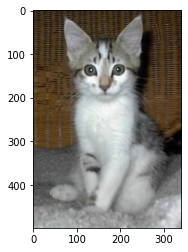

tensor([[9.9996e-01, 3.5903e-05]], device='cuda:0')
tensor([0], device='cuda:0')


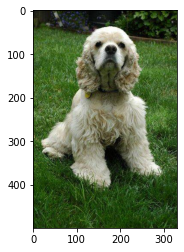

tensor([[2.0837e-04, 9.9979e-01]], device='cuda:0')
tensor([1], device='cuda:0')


In [ ]:
model.eval() # remember to switch to evaluation mode
test_transform = transforms.Compose([
        transforms.Resize(256), # for test we don't need to do augmentation
        transforms.ToTensor(),
        normalize])
from PIL import Image

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
print('classes:')
!ls test_set/test_set
print()
!ls test_set/test_set/cats
!ls test_set/test_set/dogs

model.cuda(0)

test_img = pil_loader('test_set/test_set/cats/cat.4749.jpg')
test_img2 = pil_loader('test_set/test_set/dogs/dog.4410.jpg')

imgplot = plt.imshow(test_img)
plt.show()

x = test_transform(test_img).unsqueeze_(0).cuda(0)
with torch.no_grad():
    print(torch.softmax(model(x), dim=-1))
    print(torch.argmax(model(x), dim=-1))

imgplot = plt.imshow(test_img2)
plt.show()

x = test_transform(test_img2).unsqueeze_(0).cuda(0)
with torch.no_grad():
    print(torch.softmax(model(x), dim=-1))
    print(torch.argmax(model(x), dim=-1))

# Plotting Confusion Matrix

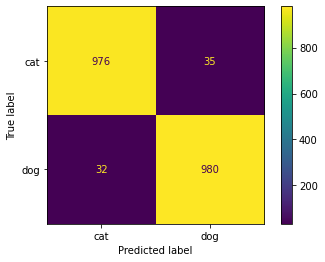

In [ ]:
# We can also plot confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
        images = images.cuda(0, non_blocking=True)
        target = target.cuda(0, non_blocking=True)

        # compute output
        output = model(images)
        y_pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        y_true.extend(target.cpu().numpy().tolist())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["cat", "dog"])
disp.plot()
plt.show()

Confusion is a uesful tool for debugging our model. The diagnal are all the correct prediction. 



#Export model as onnx file

SnapML cannot consume pytorch model directly. We need to convert our model into onnx file. 

In [ ]:
dummy_input = torch.randn(1, 3, 256, 256, dtype=torch.float32)
input_names = ["data"]
output_names = ["prob"]
model.cpu()
class ExportModel(nn.Module):
    def __init__(self, model):
        super(ExportModel, self).__init__()
        self.m = model
    def forward(self, x):
        return torch.softmax(self.m(x), dim=1)
export_model = ExportModel(model)
torch.onnx.export(export_model, dummy_input, 'mobilenetv3small' + ".onnx", verbose=False,
                  input_names=input_names, output_names=output_names, opset_version=9)
files.download('mobilenetv3small.onnx') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Lens Studio Steps to Set Up Classification Lens

1. Now we can import our model into LensStudio. Go to Lens Studio and open the ML Classification Template: https://lensstudio.snapchat.com/templates/ml/classification/

2. In the Objects panel, select ML Component.

3. Select your downloaded ONNX model.

4. In the ML Component setup popup, set up your scale and bias parameters. The scale and bias parameters are:

scale: 0.0171247, 0.017507, 0.0174291

bias: -2.1179039, -2.0357141, -1.8044444

=================

How to derive these values: 
The formula from PyTorch normalization to SnapML normalization is 

std = [0.229, 0.224, 0.225]

mean = [0.485, 0.456, 0.406]

n = (i - mean)/std

scale = [1.0 / 255 /s for s in std]

print(scale)

bias = [-m / s for m, s in zip(mean, std)] 

print(bias))

=================


5. Stretch set to False

6. In the ML Compoenet's Inspector tab, set Texture to Device Camera Texture.

7. Then in object tab add a Screen Text and Helper Script> Behavior Script

8. Finally we want to add script in our resource tab, and add Script. In the Scene Object inspector tab, set the script to run on awake, with the ML Component and screen text we added.



Note: This tutorial has referenced pytorch imagenet training example.